#**PROJET MACHINE LEARNING SUR LA PREDICTION DES PRIX DE VOITURE HYUNDAI**

## **Nettoyage des données et ingénierie des caractéristiques**

     Price    Levy Manufacturer    Model  Prod. year   Category  \
0  13328.0  1399.0        LEXUS   RX 450      2010.0       Jeep   
1  16621.0  1018.0    CHEVROLET  Equinox      2011.0       Jeep   
2   8467.0     0.0        HONDA      FIT      2006.0  Hatchback   
3   3607.0   862.0         FORD   Escape      2011.0       Jeep   
4  11726.0   446.0        HONDA      FIT      2014.0  Hatchback   

  Leather interior Fuel type Engine volume   Mileage  Cylinders Gear box type  \
0              Yes    Hybrid           3.5  186005.0        6.0     Automatic   
1               No    Petrol             3  192000.0        6.0     Tiptronic   
2               No    Petrol           1.3  200000.0        4.0      Variator   
3              Yes    Hybrid           2.5  168966.0        4.0     Automatic   
4              Yes    Petrol           1.3   91901.0        4.0     Automatic   

  Drive wheels   Doors             Wheel   Color  Airbags  
0          4x4  04-May        Left wheel  Silver  

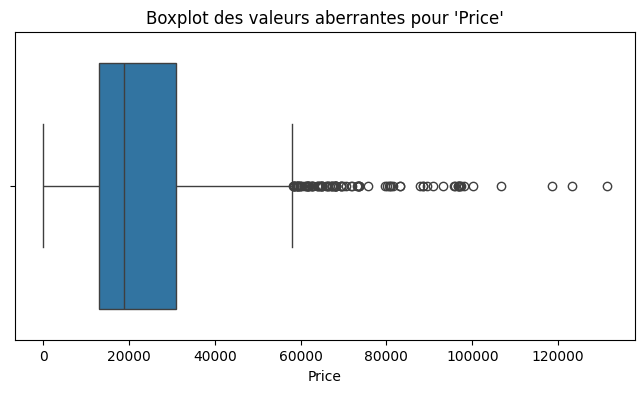

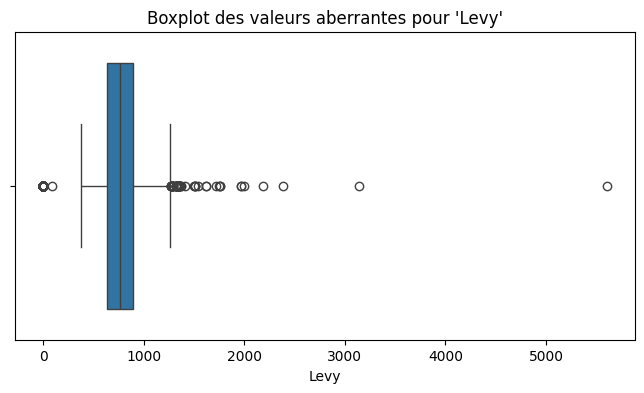

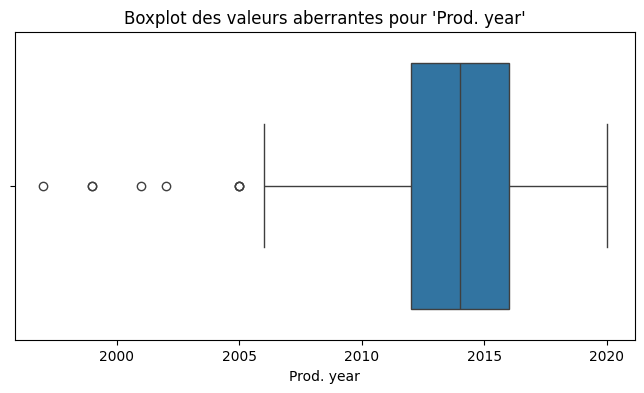

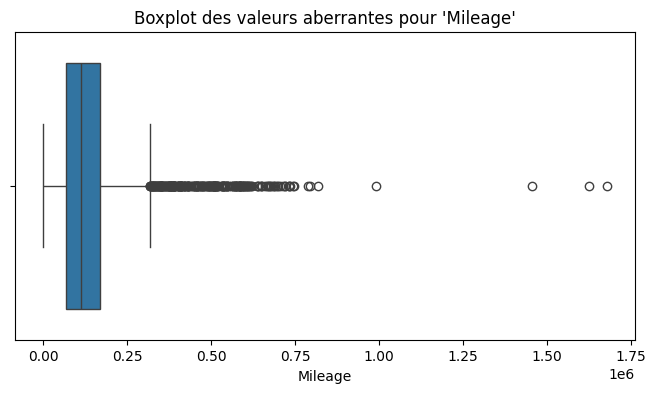

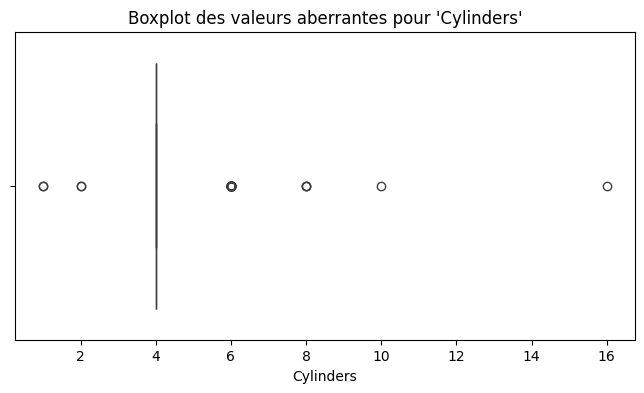

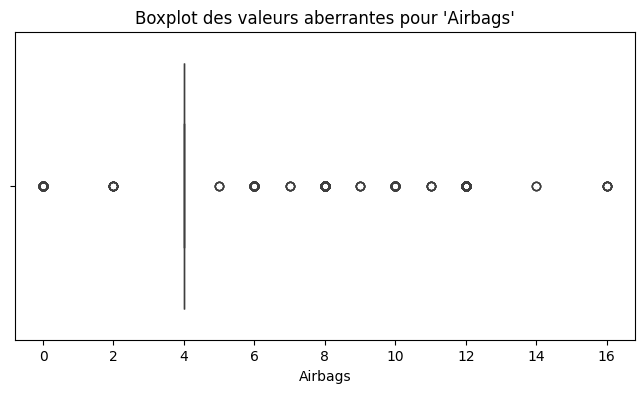

🚗 Top 100 des valeurs les plus élevées de 'Mileage' :
10644    1678000.0
14134    1624000.0
16733    1456394.0
1170      990000.0
7763      820000.0
           ...    
14583     509460.0
14697     509454.0
4130      509454.0
12100     509362.0
6278      505900.0
Name: Mileage, Length: 100, dtype: float64
🚗 Top 10 des valeurs les plus élevées de 'Mileage' :
0    587027.0
1    587027.0
2    586667.0
3    586436.0
4    585977.0
5    583499.0
6    582376.0
7    581040.0
8    577053.0
9    576605.0
Name: Mileage, dtype: float64
colonne considéré en obj Manufacturer
colonne considéré en obj Model
colonne considéré en obj Category
colonne considéré en obj Leather interior
colonne considéré en obj Fuel type
colonne considéré en obj Engine volume
colonne considéré en obj Gear box type
colonne considéré en obj Drive wheels
colonne considéré en obj Doors
colonne considéré en obj Wheel
colonne considéré en obj Color
Aperçu des données nettoyées pour les véhicules Hyundai :
      Price      Levy  M

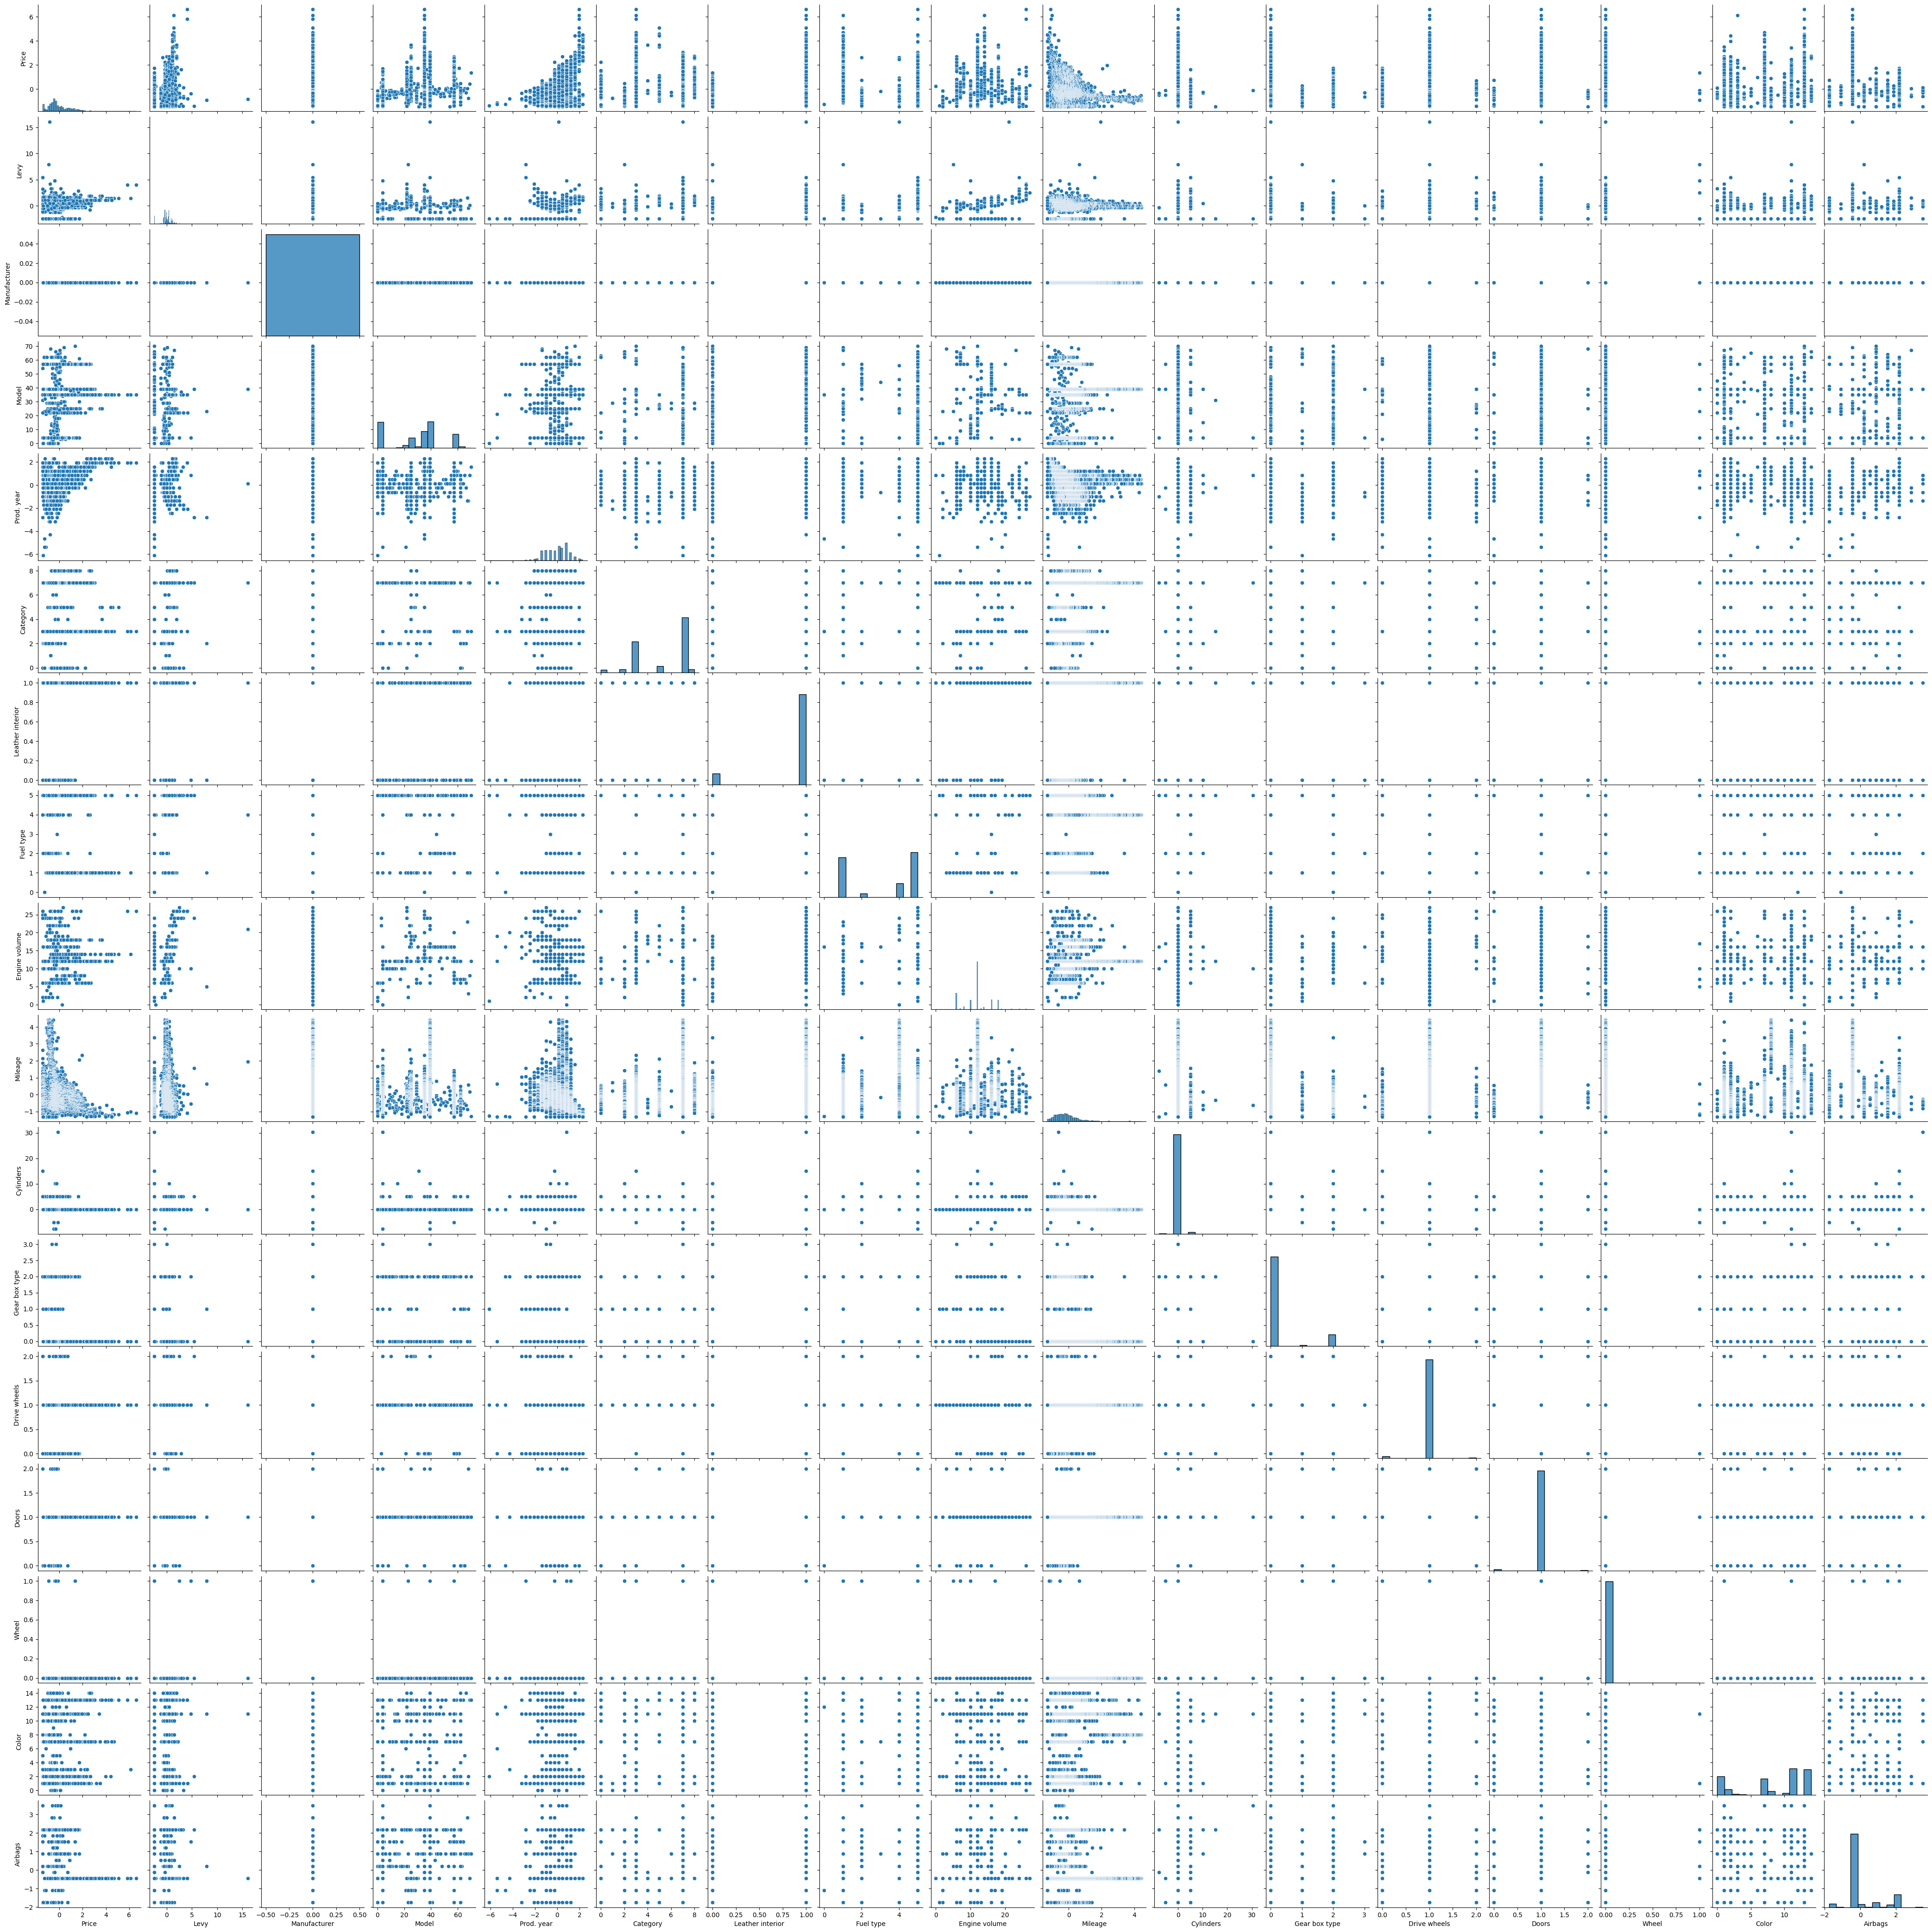

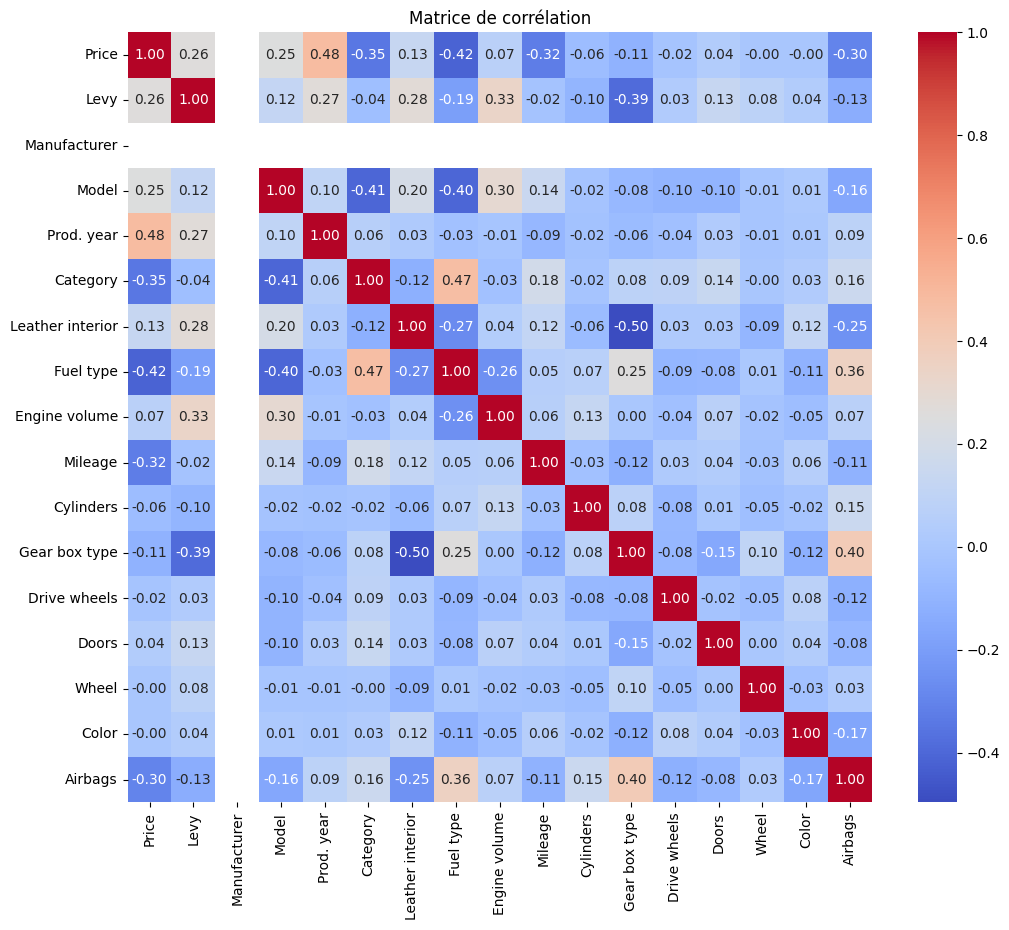

🔍 Colonnes avec une faible corrélation avec 'Price':
['Color', 'Wheel', 'Drive wheels', 'Doors', 'Cylinders', 'Engine volume']
      Price      Levy  Model  Prod. year  Category  Leather interior  \
0 -0.925115 -0.355838     39    0.107295         7                 1   
1 -0.920154 -0.355838     39    0.107295         7                 1   
2 -0.872071  0.061514     39    0.473491         7                 1   
3 -0.516745  0.061514     39    0.473491         7                 1   
4 -0.939326  0.061514     39    0.473491         7                 1   

   Fuel type   Mileage  Gear box type   Airbags  
0          4  4.425752              0 -0.443566  
1          4  4.425752              0 -0.443566  
2          4  4.422236              0 -0.443566  
3          4  4.419980              0 -0.443566  
4          4  4.415496              0 -0.443566  


In [ ]:
# Import des librairies fondamentales pour l'analyse de données et le machine learning
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import KFold

# Chargement du dataset depuis le fichier CSV
file_path = 'car_price_prediction.csv'
df = pd.read_csv(file_path)

# Nettoyage des identifiants superflus du dataset
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)
else:
    print("⚠️ La colonne 'id' n'existe pas dans le dataset. Veuillez vérifier.")

# Prétraitement des colonnes numériques :
# - Conversion des tirets en zéros pour la colonne Levy
# - Nettoyage de la colonne Mileage (suppression 'km' et virgules)
df["Levy"] = df["Levy"].str.replace('-', "0").astype(float)
df['Mileage'] = df['Mileage'].str.replace('km', '', regex=True).str.replace(',', '').astype(float)

# Affichage des premières lignes
print(df.head())

# Supprimer les doublons
df.drop_duplicates(inplace=True)

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Remplir les valeurs manquantes restantes avec la médiane (pour les valeurs numériques)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Vérification des types de données
print(df.dtypes)

# Filtrage spécifique aux véhicules Hyundai :
# - Sélection uniquement des véhicules de la marque
# - Validation des prix (doivent être positifs)
# - Vérification de la cohérence temporelle des années
if 'Manufacturer' in df.columns:
    df = df[df['Manufacturer'].str.contains('HYUNDAI', case=False, na=False)]
else:
    print("⚠️ La colonne Manufacturer n'existe pas dans le dataset. Veuillez vérifier.")
if 'price' in df.columns:
    df = df[df['price'] > 0]
# Exemple : année de fabrication valide entre 1980 et 2024
if 'year' in df.columns:
    df = df[(df['year'] >= 1980) & (df['year'] <= 2024)]

# Détection des valeurs aberrantes par méthode des quartiles :
# 1. Calcul de l'écart interquartile (IQR)
# 2. Définition des seuils (Q1 - 1.5*IQR et Q3 + 1.5*IQR)
# 3. Identification des outliers pour chaque variable numérique

# 1.
Q1 = df[numeric_cols].quantile(0.25)  # Premier quartile (25%)
Q3 = df[numeric_cols].quantile(0.75)  # Troisième quartile (75%)
IQR = Q3 - Q1  # Intervalle interquartile

# 2. Définir les bornes inférieure et supérieure pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Créer un dictionnaire pour stocker les valeurs aberrantes par colonne
outliers = {}
for col in numeric_cols:
    outliers[col] = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])]

# Visualisation des distributions et des valeurs aberrantes :
# - Création de boxplots pour chaque variable numérique
# - Identification visuelle des points extrêmes
for col, data in outliers.items():
    print(f"📊 Colonne '{col}': {len(data)} valeurs aberrantes détectées.")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot des valeurs aberrantes pour '{col}'")
    plt.show()


# Traitement spécifique du kilométrage :
# 1. Identification des 100 véhicules les plus kilométrés
# 2. Suppression des 50 cas les plus extrêmes
# 3. Vérification post-traitement avec top 10

# 1.
top_100_mileage = df['Mileage'].sort_values(ascending=False).head(100)
print("🚗 Top 100 des valeurs les plus élevées de 'Mileage' :")
print(top_100_mileage)
df = df.sort_values(by='Mileage', ascending=False)

# 2.
df = df.iloc[50:].reset_index(drop=True)

# 3.
top_10_mileage = df['Mileage'].sort_values(ascending=False).head(10)
print("🚗 Top 10 des valeurs les plus élevées de 'Mileage' :")
print(top_10_mileage)

# Encodage des variables :
# 1. Standardisation des variables numériques (moyenne=0, écart-type=1)
# 2. Encodage des variables catégorielles via LabelEncoder
# 3. Tentative de conversion numérique pour les colonnes restantes

# 1.
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 2.
label_encoder = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    print("colonne considéré en obj",col)

    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])
    try:
# 3.
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass

# Visualisation des données post-traitement :
# 1. Création d'un pairplot pour observer les relations bivariées
# 2. Génération d'une matrice de corrélation avec heatmap
# 3. Identification des variables peu corrélées avec le prix

# 1.
print("Aperçu des données nettoyées pour les véhicules Hyundai :")
print(df.head())
sns.pairplot(df)
plt.show()

# 2. Générer la matrice de corrélation
correlation_matrix = df.corr(numeric_only=True)  # Calculer la matrice de corrélation
plt.figure(figsize=(12, 10))  # Ajuster la taille de la figure si nécessaire
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # Créer le heatmap
plt.title("Matrice de corrélation") # Ajouter un titre
plt.show() # Afficher le heatmap

# 3. Identifier les colonnes avec une faible corrélation avec 'Price'
low_correlation = correlation_matrix['Price'].abs().sort_values()
low_corr_columns = low_correlation[low_correlation < 0.1].index.tolist()

print("🔍 Colonnes avec une faible corrélation avec 'Price':")
print(low_corr_columns)

# Nettoyage final :
# - Suppression des variables faiblement corrélées avec le prix
# - Retrait de la variable Manufacturer devenue redondante
df.drop(columns=low_corr_columns, inplace=True)
df.drop(columns="Manufacturer", inplace=True)
print(df.head())



## **Sélection des modèles et verification**

In [ ]:
# Préparation des données pour l'entraînement des modèles :
# - X : ensemble des variables explicatives (features)
# - y : variable cible (Price)

X = df.drop('Price', axis=1)
y = df['Price']

# Séparation des données en sets d'entraînement (80%) et de test (20%)
# random_state fixé pour assurer la reproductibilité des résultats
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle 1 : Régression Linéaire
# Entraînement d'un modèle de régression linéaire simple
# Utile comme baseline pour comparer avec des modèles plus complexes
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Évaluation du modèle linéaire avec plusieurs métriques :
# - MSE : erreur quadratique moyenne
# - RMSE : racine de l'erreur quadratique moyenne
# - MAE : erreur absolue moyenne
# - R² : coefficient de détermination
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"📊 Régression Linéaire - MSE: {mse_lin:.2f}, RMSE: {rmse_lin:.2f}, MAE: {mae_lin:.2f}, R²: {r2_lin:.2f}")


# Modèle 2 : Random Forest
# Modèle plus complexe basé sur 200 arbres de décision
# Capable de capturer des relations non-linéaires
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Évaluer le modèle Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🌳 Random Forest - MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")


# Modèle 3 : Support Vector Regression (SVR)
# Préparation spécifique : standardisation des données nécessaire pour SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuration et entraînement du SVR :
# - kernel='rbf' : noyau gaussien pour capturer les non-linéarités
# - C=1.0 : paramètre de régularisation
# - epsilon=0.1 : marge de tolérance
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

# Évaluer le modèle SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"🤖 SVR - MSE: {mse_svr:.2f}, RMSE: {rmse_svr:.2f}, MAE: {mae_svr:.2f}, R²: {r2_svr:.2f}")

# Comparaison des modèles
models_scores = {
    "Régression Linéaire": r2_lin,
    "Random Forest": r2_rf,
    "SVR": r2_svr
}

best_model = max(models_scores, key=models_scores.get)
print(f"🏆 Le meilleur modèle est : {best_model} avec un score R² de {models_scores[best_model]:.2f}")



📊 Régression Linéaire - MSE: 0.45, RMSE: 0.67, MAE: 0.49, R²: 0.53
🌳 Random Forest - MSE: 0.14, RMSE: 0.37, MAE: 0.25, R²: 0.86
🤖 SVR - MSE: 0.17, RMSE: 0.42, MAE: 0.26, R²: 0.82
🏆 Le meilleur modèle est : Random Forest avec un score R² de 0.86


## **Etude d'ablation**

In [ ]:
# Fonction d'étude d'ablation pour évaluer l'importance de chaque feature
# Analyse l'impact de la suppression de chaque variable sur les performances du modèle
def ablation_study(model, X_train, X_test, y_train, y_test, baseline_score):
    # Dictionnaire pour stocker les résultats de l'ablation pour chaque featur
    results = {}

    # Test itératif de l'impact de la suppression de chaque feature
    for col in X_train.columns:
        # Créer une copie des données sans la colonne courante
        X_train_ablation = X_train.drop(columns=[col])
        X_test_ablation = X_test.drop(columns=[col])

       # Création de nouveaux jeux de données sans la feature testée
        model.fit(X_train_ablation, y_train)
        y_pred = model.predict(X_test_ablation)

        # Calcul des métriques de performance
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        # Stockage des résultats et calcul de l'impact
        # Impact_R² : différence entre le score de base et le score sans la feature
        results[col] = {
            "R²": r2,
            "RMSE": rmse,
            "MAE": mae,
            "Impact_R²": baseline_score - r2
        }

    # Trier les résultats par l'impact sur le R²
    results = dict(sorted(results.items(), key=lambda x: x[1]['Impact_R²'], reverse=True))

    # Afficher les résultats
    for col, metrics in results.items():
        print(f"🔍 **Caractéristique retirée : {col}**")
        print(f"   - R² : {metrics['R²']:.2f}")
        print(f"   - RMSE : {metrics['RMSE']:.2f}")
        print(f"   - MAE : {metrics['MAE']:.2f}")
        print(f"   - Impact sur R² : {metrics['Impact_R²']:.4f}\n")

    return results

# Établissement de la baseline de performance
# Entraînement du modèle avec toutes les features pour référence
baseline_model = RandomForestRegressor(n_estimators=200, random_state=42)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"🏁 Score de base (R²) : {baseline_r2:.2f}")

# Lancement de l'étude d'ablation complète
# Analyse de l'importance relative de chaque feature
ablation_results = ablation_study(baseline_model, X_train, X_test, y_train, y_test, baseline_r2)

🏁 Score de base (R²) : 0.86
🔍 **Caractéristique retirée : Airbags**
   - R² : 0.77
   - RMSE : 0.47
   - MAE : 0.29
   - Impact sur R² : 0.0856

🔍 **Caractéristique retirée : Prod. year**
   - R² : 0.80
   - RMSE : 0.44
   - MAE : 0.28
   - Impact sur R² : 0.0566

🔍 **Caractéristique retirée : Fuel type**
   - R² : 0.82
   - RMSE : 0.42
   - MAE : 0.27
   - Impact sur R² : 0.0381

🔍 **Caractéristique retirée : Model**
   - R² : 0.83
   - RMSE : 0.40
   - MAE : 0.26
   - Impact sur R² : 0.0211

🔍 **Caractéristique retirée : Gear box type**
   - R² : 0.83
   - RMSE : 0.40
   - MAE : 0.26
   - Impact sur R² : 0.0208

🔍 **Caractéristique retirée : Levy**
   - R² : 0.84
   - RMSE : 0.39
   - MAE : 0.26
   - Impact sur R² : 0.0145

🔍 **Caractéristique retirée : Leather interior**
   - R² : 0.85
   - RMSE : 0.38
   - MAE : 0.25
   - Impact sur R² : 0.0072

🔍 **Caractéristique retirée : Category**
   - R² : 0.86
   - RMSE : 0.37
   - MAE : 0.25
   - Impact sur R² : -0.0015

🔍 **Caractéristique

## **Mesure d'analyse, résiduelle, courbe entre réelle et prédite**

📊 MAE : 0.25
📊 RMSE : 0.37
📊 R² : 0.86


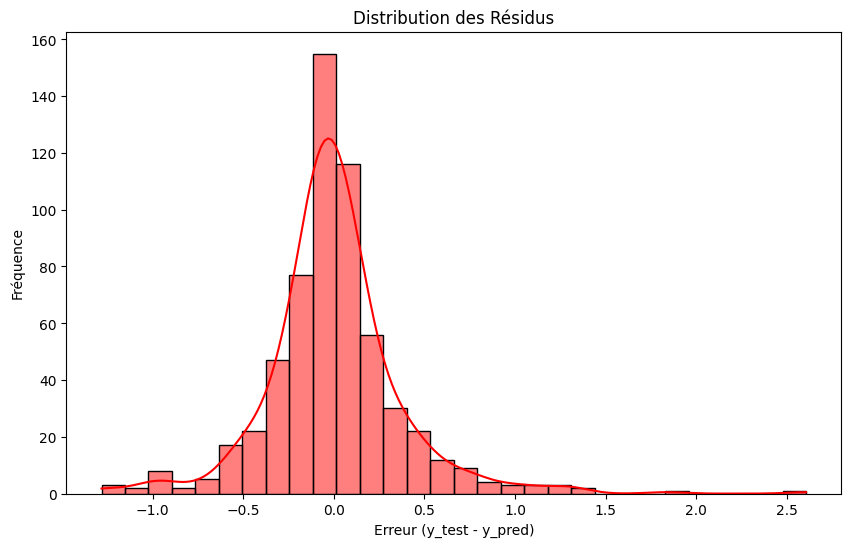

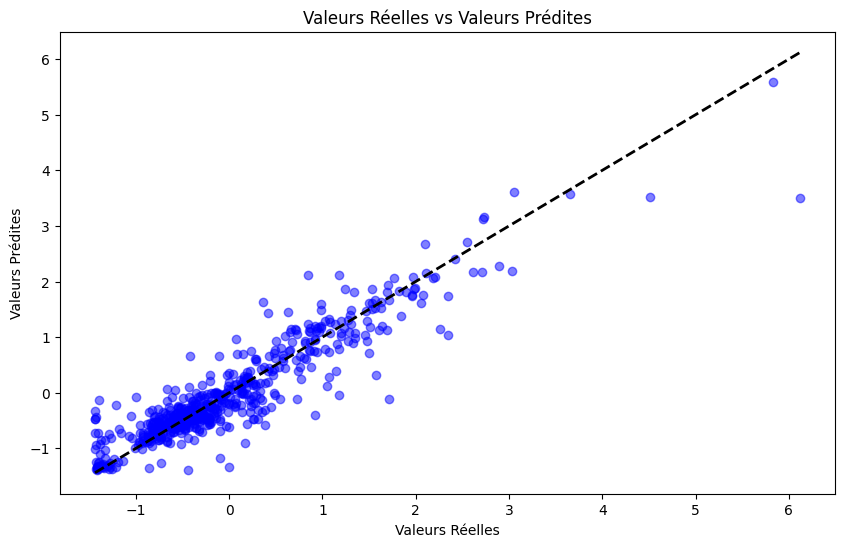

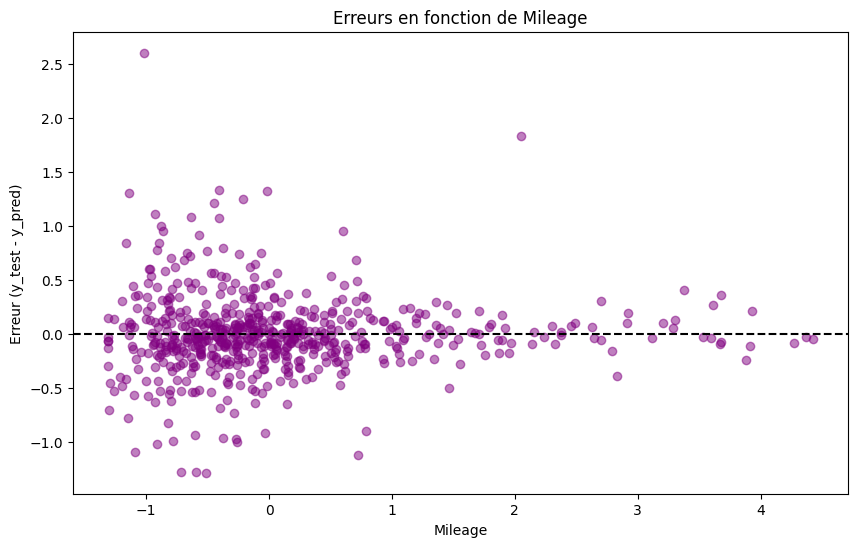

🔍 Top 10 des plus grandes erreurs :
        Actual  Predicted     Error
2811  6.115480   3.509748  2.605732
162   1.716762  -0.116981  1.833743
1840  0.001940  -1.331196  1.333136
1151  0.923972  -0.404574  1.328546
2890  2.347600   1.037826  1.309774
1502  1.571349   0.323290  1.248059
1921  1.173698  -0.043397  1.217095
2706  2.257498   1.139982  1.117516
2236 -0.094104  -1.182207  1.088103
1842  0.174794  -0.899556  1.074350


In [ ]:
# Prédictions avec le meilleur modèle
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calcul des différentes métriques d'erreur
errors = y_test - y_pred  # Calcul des résidus (différence entre valeurs réelles et prédites)
mae = mean_absolute_error(y_test, y_pred) # Erreur absolue moyenne
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Racine carrée de l'erreur quadratique moyenne
r2 = r2_score(y_test, y_pred) # Coefficient de détermination R²

# Affichage des métriques de performance avec formatage à 2 décimales
print(f"📊 MAE : {mae:.2f}") # Moyenne des valeurs absolues des erreurs
print(f"📊 RMSE : {rmse:.2f}") # Racine carrée de la moyenne des erreurs au carré
print(f"📊 R² : {r2:.2f}") # Pourcentage de variance expliquée par le modèle

# Visualisation 1 : Distribution des résidus
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='red', bins=30)
plt.title("Distribution des Résidus")
plt.xlabel("Erreur (y_test - y_pred)")
plt.ylabel("Fréquence")
plt.show()

# Visualisation 2 : Comparaison valeurs réelles vs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Valeurs Réelles vs Valeurs Prédites")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.show()

# Visualisation 3 : Analyse des résidus en fonction d'une variable explicative
feature = 'Mileage'  # Exemple de variable importante
plt.figure(figsize=(10, 6))
plt.scatter(X_test[feature], errors, alpha=0.5, color='purple')
plt.title(f"Erreurs en fonction de {feature}")
plt.xlabel(feature)
plt.ylabel("Erreur (y_test - y_pred)")
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Afficher les 10 plus grandes erreurs
error_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred, "Error": errors})
top_errors = error_df.sort_values(by="Error", ascending=False).head(10)
print("🔍 Top 10 des plus grandes erreurs :")
print(top_errors)

## **cross validation : méthode K-Fold Cross-Validation**

In [ ]:
model = RandomForestRegressor(n_estimators=200, random_state=42)

# Définir le validateur K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Définir une métrique personnalisée (RMSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Exécuter la validation croisée
cv_scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)

# Afficher les résultats
print("📊 Scores RMSE pour chaque fold:", np.sqrt(-cv_scores))
print(f"📊 RMSE moyen : {np.sqrt(-cv_scores).mean():.2f}")

📊 Scores RMSE pour chaque fold: [0.36942697 0.37814088 0.35231474 0.30075175 0.37614667]
📊 RMSE moyen : 0.36


## **modèle de base : baseline aléatoire**

In [23]:
# Prédiction baseline sur la moyenne du prix
y_pred_baseline = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# Évaluation du modèle baseline
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"🛠️ Modèle Baseline random - MSE: {mse_baseline:.2f}, R²: {r2_baseline:.2f}")

🛠️ Modèle Baseline random - MSE: 0.95, R²: -0.00
